# Reproducing Key Figures from Kay et al. (2015) Paper


## Introduction

This Jupyter Notebook demonstrates how one might use the NCAR Community Earth System Model (CESM)
Large Ensemble (LENS) data hosted on AWS S3 ([doi:10.26024/wt24-5j82](https://doi.org/10.26024/wt24-5j82)). The notebook shows how to reproduce figures 2 and 4 from the Kay et al. (2015) paper describing the CESM LENS dataset ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

This resource is intended to be helpful for people not familiar with elements of the [Pangeo](https://pangeo.io) framework including Jupyter Notebooks, [Xarray](http://xarray.pydata.org/), and [Zarr](https://zarr.readthedocs.io/) data format, or with the original paper, so it includes additional explanation.


## Set up environment

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr

## Create and Connect to Dask Distributed Cluster

In [2]:
# Create cluster
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=2, maximum=100)
# Connect to cluster
client = Client(cluster)
# Display cluster dashboard URL
cluster


☝️ Link to scheduler dashboard will appear above.

## Load data into xarray from a catalog using intake-esm

- [Intake-esm Documentation](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html)

In [3]:
# Open collection description file
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(catalog_url)
col

,unique
component,5
frequency,6
experiment,4
variable,65
path,394
variable_long_name,62
dim_per_tstep,3
start,13
end,12


In [4]:
# Show the first few lines of the catalog
col.df.head(10)

,component,frequency,experiment,variable,path,variable_long_name,dim_per_tstep,start,end
0,atm,daily,20C,FLNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....,net longwave flux at surface,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
1,atm,daily,20C,FLNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...,clearsky net longwave flux at surface,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
2,atm,daily,20C,FLUT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....,upwelling longwave flux at top of model,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
3,atm,daily,20C,FSNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....,net solar flux at surface,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
4,atm,daily,20C,FSNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...,clearsky net solar flux at surface,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
5,atm,daily,20C,FSNTOA,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNTO...,net solar flux at top of atmosphere,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
6,atm,daily,20C,ICEFRAC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-ICEFR...,fraction of sfc area covered by sea-ice,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
7,atm,daily,20C,LHFLX,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-LHFLX...,surface latent heat flux,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
8,atm,daily,20C,PRECL,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECL...,large-scale (stable) precipitation rate (liq +...,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
9,atm,daily,20C,PRECSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECS...,convective snow rate (water equivalent),2.0,1920-01-01 12:00:00,2005-12-30 12:00:00


In [5]:
# Show expanded version of collection structure with details
import pprint
uniques = col.unique(columns=["component", "frequency", "experiment", "variable"])
pprint.pprint(uniques, compact=True, indent=4)

{   'component': {   'count': 5,
                     'values': ['atm', 'ice_nh', 'ice_sh', 'lnd', 'ocn']},
    'experiment': {'count': 4, 'values': ['20C', 'CTRL', 'HIST', 'RCP85']},
    'frequency': {   'count': 6,
                     'values': [   'daily', 'hourly6-1990-2005',
                                   'hourly6-2026-2035', 'hourly6-2071-2080',
                                   'monthly', 'static']},
    'variable': {   'count': 65,
                    'values': [   'DIC', 'DOC', 'FLNS', 'FLNSC', 'FLUT', 'FSNO',
                                  'FSNS', 'FSNSC', 'FSNTOA', 'FW', 'H2OSNO',
                                  'HMXL', 'ICEFRAC', 'LHFLX', 'O2', 'PD',
                                  'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PSL',
                                  'Q', 'QFLUX', 'QRUNOFF', 'QSW_HBL', 'QSW_HTP',
                                  'RAIN', 'RESID_S', 'SALT', 'SFWF',
                                  'SFWF_WRST', 'SHF', 'SHFLX', 'SHF_QSW',
               

## Extract data needed to construct Figure 2 of Kay et al. paper

Search the catalog to find the desired data, in this case the reference height temperature
of the atmosphere, at daily time resolution, for the Historical, 20th Century, and RCP8.5 (IPCC 
Representative Concentration Pathway 8.5) experiments

In [6]:
col_subset = col.search(frequency=["daily", "monthly"], component="atm", variable="TREFHT", 
                        experiment=["20C", "RCP85", "HIST"])

col_subset

,unique
component,1
frequency,2
experiment,3
variable,1
path,6
variable_long_name,1
dim_per_tstep,2
start,6
end,6


In [7]:
col_subset.df

,component,frequency,experiment,variable,path,variable_long_name,dim_per_tstep,start,end
0,atm,daily,20C,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TREFH...,reference height temperature,2.0,1920-01-01 12:00:00,2005-12-30 12:00:00
1,atm,daily,HIST,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-HIST-TREF...,reference height temperature,1.0,1850-01-01 00:00:00,1919-12-31 12:00:00
2,atm,daily,RCP85,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-TRE...,reference height temperature,2.0,2006-01-01 12:00:00,2100-12-31 12:00:00
3,atm,monthly,20C,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-TRE...,reference height temperature,2.0,1920-01-16 12:00:00,2005-12-16 12:00:00
4,atm,monthly,HIST,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-TR...,reference height temperature,1.0,1850-01-16 12:00:00,1919-12-16 12:00:00
5,atm,monthly,RCP85,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...,reference height temperature,2.0,2006-01-16 12:00:00,2100-12-16 12:00:00


In [8]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['atm.20C.monthly', 'atm.RCP85.daily', 'atm.RCP85.monthly', 'atm.HIST.daily', 'atm.HIST.monthly', 'atm.20C.daily'])


In [9]:
# Define Xarray datasets corresponding to the three experiments
ds_HIST = dsets['atm.HIST.monthly']
ds_20C = dsets['atm.20C.daily']
ds_RCP85 = dsets['atm.RCP85.daily']

In [10]:
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes
print(f"Historical: {format_bytes(ds_HIST.nbytes)}\n"
      f"20th Century: {format_bytes(ds_20C.nbytes)}\n"
      f"RCP8.5: {format_bytes(ds_RCP85.nbytes)}")

Historical: 185.82 MB
20th Century: 277.71 GB
RCP8.5: 306.78 GB


In [11]:
# Extract the Reference Height Temperature data variable
t_hist = ds_HIST["TREFHT"]
t_20c = ds_20C["TREFHT"]
t_rcp = ds_RCP85["TREFHT"]
t_20c

,Array,Chunk
Bytes,277.71 GB,127.40 MB
Shape,"(40, 31389, 192, 288)","(1, 576, 192, 288)"
Count,2201 Tasks,2200 Chunks
Type,float32,numpy.ndarray


In [12]:
# The global surface temperature anomaly was computed relative to the 1961-90 base period
# in the Kay et al. paper, so extract that time slice
t_ref = t_20c.sel(time=slice("1961", "1990"))

## Read grid cell areas

Cell size varies with latitude, so this must be accounted for when computing the global mean.


In [17]:
cat = col.search(frequency="static", component="atm", experiment=["20C"])
_, grid = cat.to_dataset_dict(aggregate=False, zarr_kwargs={"consolidated": True}).popitem()
grid


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.frequency.experiment.variable.path.variable_long_name.dim_per_tstep.start.end'


<xarray.Dataset>
Dimensions:   (bnds: 2, ilev: 31, lat: 192, lev: 30, lon: 288, slat: 191, slon: 288)
Coordinates:
    P0        float64 ...
    area      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    gw        (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyai      (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam      (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi      (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm      (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
  * ilev      (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    ntrk      int32 ...
    ntrm      int32 ...
    ntrn      int32 ...
  * slat      (slat) float64 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon      (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
    w_stag    (slat) float64 dask.array<chunksize=(191,), meta=np.ndarray>
    wnummax   (lat) int32 dask.array<chunksize=(192,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    *empty*
Attributes:
    intake_esm_dataset_key:  atm.static.20C.nan.s3://ncar-cesm-lens/atm/stati...

In [19]:
cell_area = grid.area.load()
total_area = cell_area.sum()
cell_area

<xarray.DataArray 'area' (lat: 192, lon: 288)>
array([[2.994837e+07, 2.994837e+07, 2.994837e+07, ..., 2.994837e+07,
        2.994837e+07, 2.994837e+07],
       [2.395748e+08, 2.395748e+08, 2.395748e+08, ..., 2.395748e+08,
        2.395748e+08, 2.395748e+08],
       [4.790848e+08, 4.790848e+08, 4.790848e+08, ..., 4.790848e+08,
        4.790848e+08, 4.790848e+08],
       ...,
       [4.790848e+08, 4.790848e+08, 4.790848e+08, ..., 4.790848e+08,
        4.790848e+08, 4.790848e+08],
       [2.395748e+08, 2.395748e+08, 2.395748e+08, ..., 2.395748e+08,
        2.395748e+08, 2.395748e+08],
       [2.994837e+07, 2.994837e+07, 2.994837e+07, ..., 2.994837e+07,
        2.994837e+07, 2.994837e+07]], dtype=float32)
Coordinates:
    P0       float64 1e+05
    area     (lat, lon) float32 29948370.0 29948370.0 ... 29948370.0 29948370.0
    gw       (lat) float64 3.382e-05 nan nan nan nan ... nan nan nan 3.382e-05
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    ntrk     int32 1
    ntrm     int32 1
    ntrn     int32 1
    wnummax  (lat) int32 1 -2147483648 -2147483648 ... -2147483648 -2147483648 1
Attributes:
    long_name:      Grid-Cell Area
    standard_name:  cell_area
    units:          m2

## Define weighted means

Note: `resample(time="AS")` does an Annual resampling based on Start of calendar year.

See documentation for [Pandas resampling options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [20]:
t_ref_ts = (
    (t_ref.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
    / total_area
).mean(dim=("time", "member_id"))

t_hist_ts = (
    (t_hist.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_20c_ts = (
    (t_20c.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_rcp_ts = (
    (t_rcp.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

## Read data and compute means

Note: Dask's "lazy execution" philosophy means that until this point we have not actually read the bulk of the data. These steps take a while to complete, so we include the Notebook "cell magic" directive `%%time` to display elapsed and CPU times after computation.

In [21]:
%%time
t_ref_mean = t_ref_ts.load()
t_ref_mean

CPU times: user 6.12 s, sys: 102 ms, total: 6.22 s
Wall time: 3min 26s


<xarray.DataArray ()>
array(286.38766, dtype=float32)
Coordinates:
    P0       float64 1e+05
    ntrk     int32 1
    ntrm     int32 1
    ntrn     int32 1

In [22]:
%%time
t_hist_ts_df = t_hist_ts.to_series().T
t_hist_ts_df.head()

CPU times: user 331 ms, sys: 15.4 ms, total: 347 ms
Wall time: 1.6 s


time
1850-01-01 00:00:00    286.205444
1851-01-01 00:00:00    286.273590
1852-01-01 00:00:00    286.248016
1853-01-01 00:00:00    286.240753
1854-01-01 00:00:00    286.150757
dtype: float32

In [23]:
%%time
t_20c_ts_df = t_20c_ts.to_series().unstack().T
t_20c_ts_df.head()

CPU times: user 17.8 s, sys: 715 ms, total: 18.5 s
Wall time: 1min 15s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
1920-01-01 00:00:00,286.311676,286.346863,286.283936,286.365051,286.328400,286.374512,286.387177,286.302338,286.376007,286.348663,...,286.243713,286.283813,286.174377,286.309479,286.297028,286.342316,286.342346,286.378021,286.322083,286.255188
1921-01-01 00:00:00,286.249603,286.198578,286.287506,286.390289,286.309784,286.334747,286.309937,286.300873,286.314240,286.306244,...,286.178558,286.316467,286.073853,286.296082,286.317352,286.374298,286.246185,286.355591,286.493042,286.224823
1922-01-01 00:00:00,286.293854,286.296844,286.265747,286.336914,286.293915,286.218872,286.010254,286.195770,286.205841,286.396942,...,286.143463,286.316132,286.140900,286.294434,286.327911,286.142883,286.413239,286.368683,286.502197,286.281860
1923-01-01 00:00:00,286.327942,286.321838,286.251160,286.322327,286.236725,286.151855,286.066864,286.203583,286.271698,286.291260,...,286.168610,286.300781,286.096191,286.115479,286.227142,286.226837,286.512238,286.381165,286.215485,286.396912
1924-01-01 00:00:00,286.308380,286.238281,286.147858,286.311798,286.362732,286.185822,286.249084,286.288116,286.330627,286.411957,...,286.142395,286.287109,286.233795,286.201202,286.253906,286.323425,286.255035,286.221741,286.247589,286.421387


In [24]:
%%time
t_rcp_ts_df = t_rcp_ts.to_series().unstack().T
t_rcp_ts_df.head()

CPU times: user 19.4 s, sys: 539 ms, total: 19.9 s
Wall time: 1min 22s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,286.764832,286.960358,286.679230,286.793152,286.754547,287.022339,286.850464,287.089844,286.960022,286.775787,...,286.866089,286.925049,286.663971,286.955414,286.712524,287.115601,286.863556,286.881683,287.308411,287.030334
2007-01-01 00:00:00,287.073792,286.908539,286.808746,286.998901,286.841675,286.993042,286.914124,286.938965,286.933563,286.675385,...,286.804108,286.849548,286.628204,287.010529,286.811554,287.187225,286.862823,287.008270,287.222534,287.239044
2008-01-01 00:00:00,287.104095,286.815033,286.995056,287.081543,287.100708,286.960510,286.854706,286.878937,287.062927,286.702454,...,286.825653,286.844086,286.811859,286.803741,286.956635,287.080994,286.930084,286.945801,287.087128,287.157745
2009-01-01 00:00:00,286.984497,287.059448,287.010498,287.144714,286.948700,287.092316,286.888458,287.050934,287.138428,286.890839,...,286.785797,286.876556,286.953094,287.060364,287.056946,287.124908,287.005615,287.083984,287.254211,287.060730
2010-01-01 00:00:00,286.991821,287.102295,286.988129,286.875183,286.954407,287.121796,286.938843,287.116211,286.957245,287.049622,...,286.937317,286.928314,286.980499,287.118713,287.178040,287.030212,287.114716,287.083038,287.256927,287.066528


## Get observations for figure 2 (HadCRUT4; Morice et al. 2012)

In [25]:
# Observational time series data for comparison with ensemble average
obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc"

In [26]:
ds = xr.open_dataset(obsDataURL).load()
ds

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 72, nbnds: 2, time: 2046)
Coordinates:
  * lat        (lat) float32 87.5 82.5 77.5 72.5 ... -72.5 -77.5 -82.5 -87.5
  * lon        (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2020-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1850-01-01 1850-01-31 ... 2020-06-30
    air        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    platform:                        Surface
    title:                           HADCRUT4 Combined Air Temperature/SST An...
    history:                         Originally created at NOAA/ESRL PSD by C...
    Conventions:                     CF-1.0
    Comment:                         This dataset supersedes V3
    Source:                          Obtained from http://hadobs.metoffice.co...
    version:                         4.2.0
    dataset_title:                   HadCRUT4
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    DODS_EXTRA.Unlimited_Dimension:  time

In [27]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    time_bound_diff = ds.time_bnds.diff(dim="nbnds")[:, 0]
    wgts = time_bound_diff.groupby("time.year") / time_bound_diff.groupby(
        "time.year"
    ).sum(xr.ALL_DIMS)
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    obs = ds["air"]
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    obs_s = (obs_sum / ones_out).mean(("lat", "lon")).to_series()
    return obs_s

- **Limit Observations to 20th Century**

In [28]:
obs_s = weighted_temporal_mean(ds)
obs_s = obs_s['1920':]
obs_s.head()

time
1920-01-01   -0.262006
1921-01-01   -0.195891
1922-01-01   -0.301986
1923-01-01   -0.269062
1924-01-01   -0.292857
Freq: AS-JAN, dtype: float64

In [29]:
all_ts_anom = pd.concat([t_20c_ts_df, t_rcp_ts_df]) - t_ref_mean.data
years = [val.year for val in all_ts_anom.index]
obs_years = [val.year for val in obs_s.index]

In [30]:
# Combine ensemble member 1 data from historical and 20th century experiments
hist_anom = t_hist_ts_df - t_ref_mean.data
member1 = pd.concat([hist_anom.iloc[:-2], all_ts_anom.iloc[:,0]], verify_integrity=True)
member1_years = [val.year for val in member1.index]

## Figure 2: Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations

In [31]:
import matplotlib.pyplot as plt

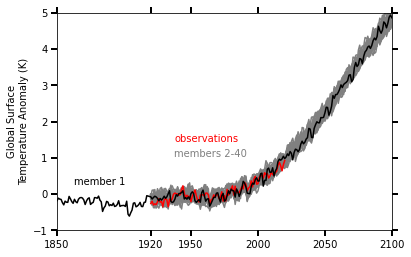

In [32]:
ax = plt.axes()

ax.tick_params(right=True, top=True, direction="out", length=6, width=2, grid_alpha=0.5)
ax.plot(years, all_ts_anom.iloc[:,1:], color="grey")
ax.plot(obs_years, obs_s['1920':], color="red")
ax.plot(member1_years, member1, color="black")


ax.text(
    0.35,
    0.4,
    "observations",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="red",
    fontsize=10,
)
ax.text(
    0.35,
    0.33,
    "members 2-40",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="grey",
    fontsize=10,
)
ax.text(
    0.05,
    0.2,
    "member 1",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
)

ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
plt.ylim(-1, 5)
plt.xlim(1850, 2100)
plt.ylabel("Global Surface\nTemperature Anomaly (K)")
plt.show()

Figure will appear above when ready. Compare with Fig.2 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

![figure-2](./images/bams-d-13-00255_1-f2.jpeg)

## Compute linear trend for winter seasons

In [33]:
def linear_trend(da, dim="time"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = np.nan if (np.sum(finite_indexes) < 2) else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    return slope

## Compute ensemble trends

In [34]:
t = xr.concat([t_20c, t_rcp], dim="time")
seasons = t.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 and 2012
seasons = seasons.sel(time=slice("1979", "2012")).load()


In [35]:
winter_seasons = seasons.sel(
    time=seasons.time.where(seasons.time.dt.month == 12, drop=True)
)
winter_trends = linear_trend(
    winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(winter_seasons.time)

# Compute ensemble mean from the first 30 members
winter_trends_mean = winter_trends.isel(member_id=range(30)).mean(dim='member_id')

In [36]:
# Make sure that we have 34 seasons
assert len(winter_seasons.time) == 34

## Get Observations for Figure 4 (NASA GISS GisTemp)

In [37]:
# Observational time series data for comparison with ensemble average
# NASA GISS Surface Temperature Analysis, https://data.giss.nasa.gov/gistemp/
obsDataURL = "https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz"

In [38]:
# Download, unzip, and load file
import os
os.system("wget " + obsDataURL)

obsDataFileName = obsDataURL.split('/')[-1]
os.system("gunzip " + obsDataFileName)

obsDataFileName = obsDataFileName[:-3]
ds = xr.open_dataset(obsDataFileName).load()
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1687)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2020-07-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2020-08-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 0.55 0.55 0.55
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2020-08-13 09:26:17 by SBBX_to_nc 2.0 - ILAND=1200,...

In [39]:
# Remap longitude range from [-180, 180] to [0, 360] for plotting purposes
ds = ds.assign_coords(lon=((ds.lon + 360) % 360)).sortby('lon')
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1687)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2020-07-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2020-08-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 0.55 0.55 0.55
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2020-08-13 09:26:17 by SBBX_to_nc 2.0 - ILAND=1200,...

## Compute observed trends

In [40]:
obs_seasons = ds.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 through 2012
obs_seasons = obs_seasons.sel(time=slice("1979", "2012")).load()

# Compute observed winter trends
obs_winter_seasons = obs_seasons.sel(
    time=obs_seasons.time.where(obs_seasons.time.dt.month == 12, drop=True)
)
obs_winter_seasons

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 34)
Coordinates:
  * time         (time) datetime64[ns] 1979-12-01 1980-12-01 ... 2012-12-01
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tempanomaly  (time, lat, lon) float32 0.5333333 0.5333333 ... 7.47 7.47

In [41]:
obs_winter_trends = linear_trend(
    obs_winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(obs_winter_seasons.time)
obs_winter_trends

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180)
Coordinates:
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tempanomaly  (lat, lon) float64 1.284 1.284 1.284 ... 5.672 5.672 5.672

## Figure 4: Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends

In [42]:
import cmaps  # for NCL colormaps
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

contour_levels = [-6, -5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5, 6]

color_map = cmaps.ncl_default

In [43]:
def make_map_plot(nplot_rows, nplot_cols, plot_index, data, plot_label):
    """ Create a single map subplot. """
    ax = plt.subplot(nplot_rows, nplot_cols, plot_index, projection = ccrs.Robinson(central_longitude = 180))
    cplot = plt.contourf(lons, lats, data, 
                         levels = contour_levels, 
                         cmap = color_map, 
                         extend = 'both', 
                         transform = ccrs.PlateCarree())
    ax.coastlines(color = 'grey')
    ax.text(0.01, 0.01, plot_label, fontSize = 14, transform = ax.transAxes)
    return cplot, ax

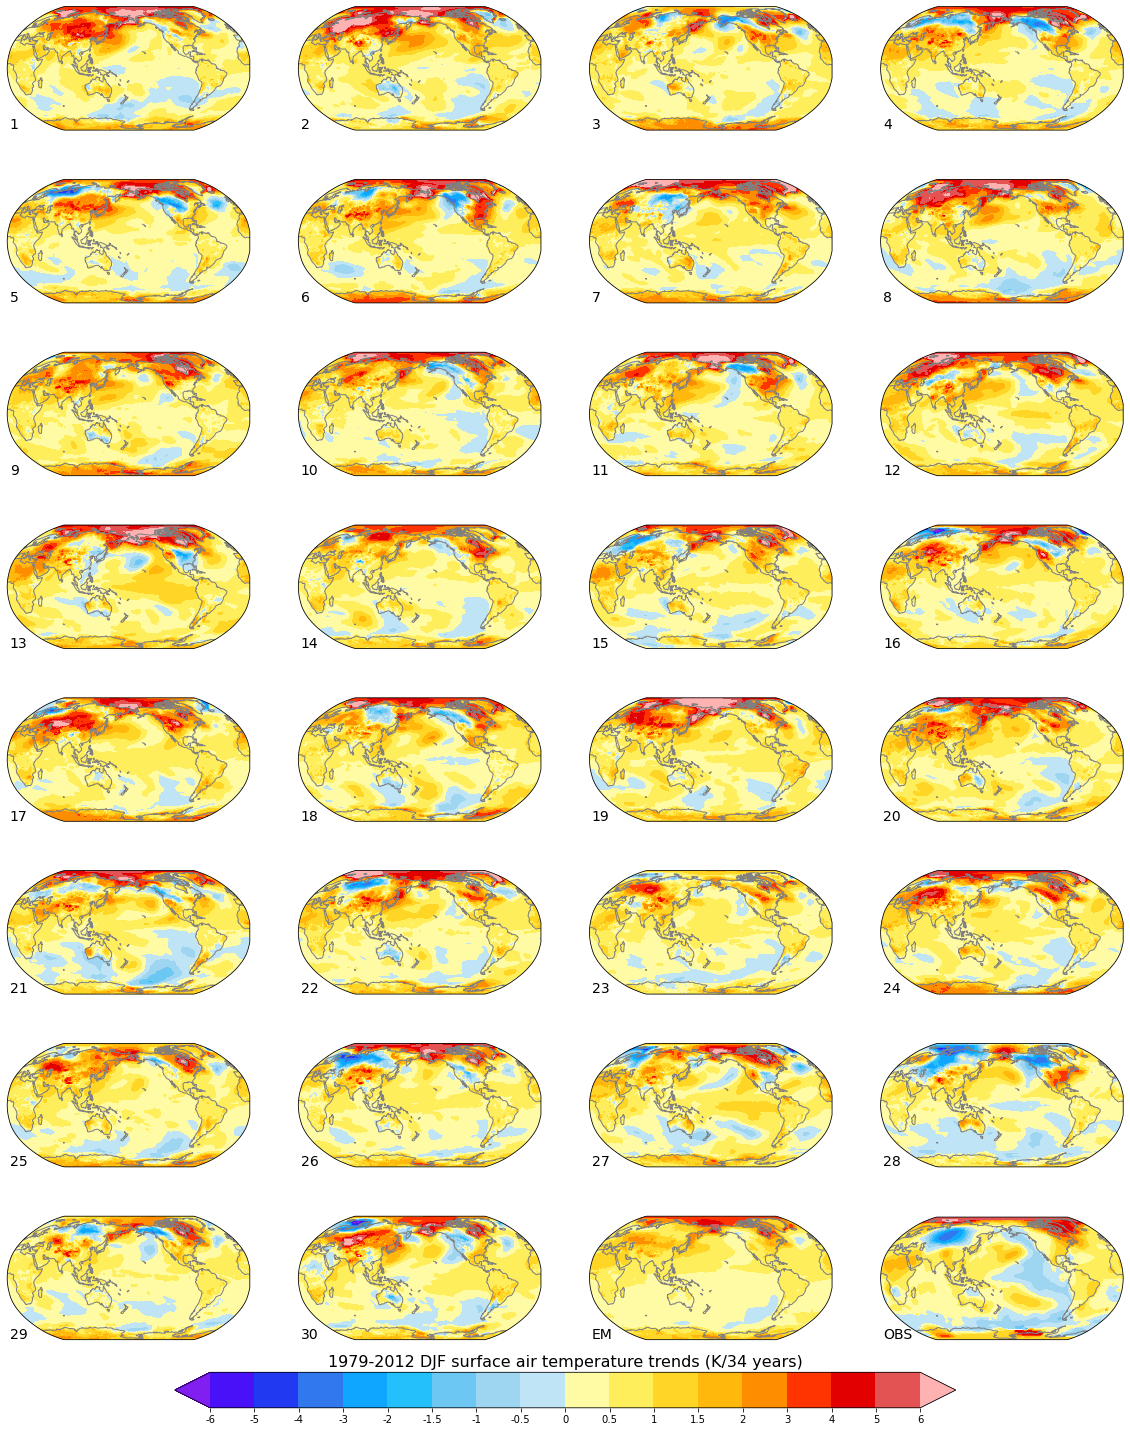

In [44]:
# Generate plot (may take a while as many individual maps are generated)
numPlotRows = 8
numPlotCols = 4
figWidth = 20 
figHeight = 30 
 
fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight))

lats = winter_trends.lat
lons = winter_trends.lon

# Create ensemble member plots
for ensemble_index in range(30):
    plot_data = winter_trends.isel(member_id = ensemble_index)
    plot_index = ensemble_index + 1
    plot_label = str(plot_index)
    plotRow = ensemble_index // numPlotCols
    plotCol = ensemble_index % numPlotCols
    # Retain axes objects for figure colorbar
    cplot, axs[plotRow, plotCol] = make_map_plot(numPlotRows, numPlotCols, plot_index, plot_data, plot_label)

# Create plots for the ensemble mean, observations, and a figure color bar.
cplot, axs[7,2] = make_map_plot(numPlotRows, numPlotCols, 31, winter_trends_mean, 'EM')

lats = obs_winter_trends.lat
lons = obs_winter_trends.lon
cplot, axs[7,3] = make_map_plot(numPlotRows, numPlotCols, 32, obs_winter_trends.tempanomaly, 'OBS')  

cbar = fig.colorbar(cplot, ax=axs, orientation='horizontal', shrink = 0.7, pad = 0.02)
cbar.ax.set_title('1979-2012 DJF surface air temperature trends (K/34 years)', fontSize = 16)
cbar.set_ticks(contour_levels)
cbar.set_ticklabels(contour_levels)

Figure will appear above when ready. Compare with Fig. 4 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1)).

![](./images/bams-d-13-00255_1-f4.png)


In [ ]:
# Gracefully destroy/close our cluster
client.close()
cluster.close()